# Tutorial | Gravitational wave science

In the following tutorial we will explore the potentials of skreducedmodel using a set of gravitational waves. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The example data are located in the "waveforms" directory. The files contain 100 gravitational waves with real and imaginary part for a set of parameters. 
In this example, the gravitational wave data correspond to simulated data generated by the interaction of a compact binary system. The q parameter correspond to the mass ratio.
There is also a file with the times. Both waveforms and parameters are divided into a training set and a test set. 

In [2]:
path = "../../../tests/waveforms/"
q_train = np.load(path+"q_train_1d-seed_eq_1.npy")
q_test = np.load(path+"q_test_1d-seed_eq_1.npy")
ts_train = np.load(path+"ts_train_1d-seed_eq_1.npy")
ts_test = np.load(path+"ts_test_1d-seed_eq_1.npy")
times = np.load(path+"times_1d-seed_eq_1.npy")
# ts_test_normalized = normalize_set(ts_test, times)

### Reduced Basis

parameter value:  q = [8. 0. 0.]


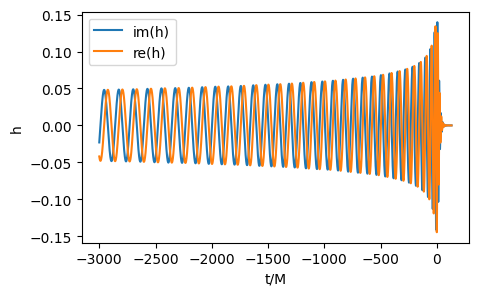

In [3]:
idx = 1
print('parameter value: ',f"q = {q_train[idx]}")

plt.figure(figsize=(5,3))

plt.xlabel("t/M")
plt.ylabel("h")
plt.plot(times,np.imag(ts_train[idx]), label="im(h)")
plt.plot(times,np.real(ts_train[idx]), label="re(h)")
plt.legend();

We will start by building the reduced base. When instantiating the class we will set the desired parameters. The parameter "index_seed_blobal_rb" selects the "seed" wave which is the first element of the reduced base. With "greedy_tol" we select the desired precision, "lmax" defines the maximum depth of the tree built in the domain partition (number of leaves) and "nmax" the maximum number of base elements. With "normalize" we have the option to normalise the data before constructing the basis and finally we select the desired integration rule. With the fit method we train the greedy algorithm that constructs the reduced basis. 

In [4]:
from skreducedmodel.reducedbasis import ReducedBasis

rb = ReducedBasis(index_seed_global_rb = 0,
                  greedy_tol = 1e-16,
                  lmax = 2,
                  nmax = 5,
                  normalize = True,
                  integration_rule="riemann"
                  )

rb.fit(training_set = ts_train,
       parameters = q_train,
       physical_points = times
       )

With anytree we can visualise the constructed tree 

In [5]:
from anytree import RenderTree

def visual_tree(tree):
    for pre, fill, node in RenderTree(tree):
        print("%s%s" % (pre, node.name))

visual_tree(rb.tree)

(0,)
├── (0, 0)
│   ├── (0, 0, 0)
│   └── (0, 0, 1)
└── (0, 1)
    ├── (0, 1, 0)
    └── (0, 1, 1)


Now we visualise how the training parameters were divided into the created partitions. Each colour indicates a different leaf of the tree and on the x-axis we have the parameter values. 

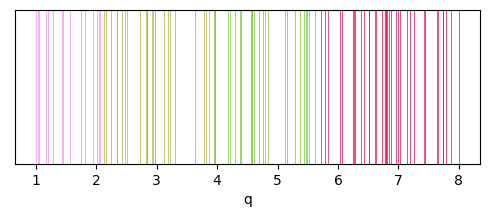

In [6]:
plt.figure(figsize=(6,2))

np.random.seed(seed=4)
plt.xlabel("q")
plt.yticks([])

for leaf in rb.tree.leaves:
    color = np.random.rand(3,)
    for p in leaf.train_parameters[:,0]:
        plt.axvline(p,c=color,lw=.5)

Let us now look at the dependence of the reduced base error on the parameter q. For this we will use the normalize_set and error functions of skreducedmodel. In turn, we will use the transform method of ReducedBasis. 

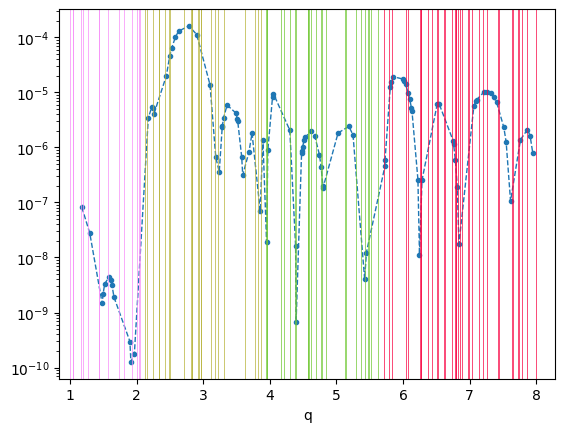

In [7]:
from skreducedmodel.reducedbasis import normalize_set, error

# we normalise the set of test waveforms
ts_test_normalized = normalize_set(ts_test, times)

# we calculate the wave projection with the hp-greedy model
hts = []
for h, q in zip(ts_test_normalized, q_test):
    hts.append(rb.transform(h,q))
hts = np.array(hts)

# we calculate the error for each of the projections
errors = []
for i in range(ts_test_normalized.shape[0]):
    errors.append(error(ts_test_normalized[i], hts[i], times))

# we plot the dependence of the errors on the parameter q
plt.yscale("log")
plt.plot(np.sort(q_test[:,0]), np.array(errors)[np.argsort(q_test[:,0])], "o--", ms=3, lw=1);

np.random.seed(seed=4)
plt.xlabel("q")
for leaf in rb.tree.leaves:
    color = np.random.rand(3,)
    for p in leaf.train_parameters[:,0]:
        plt.axvline(p,c=color,lw=.5)

Ploteamos una onda proyectada vs la normal

/home/agus/scikit_surr/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


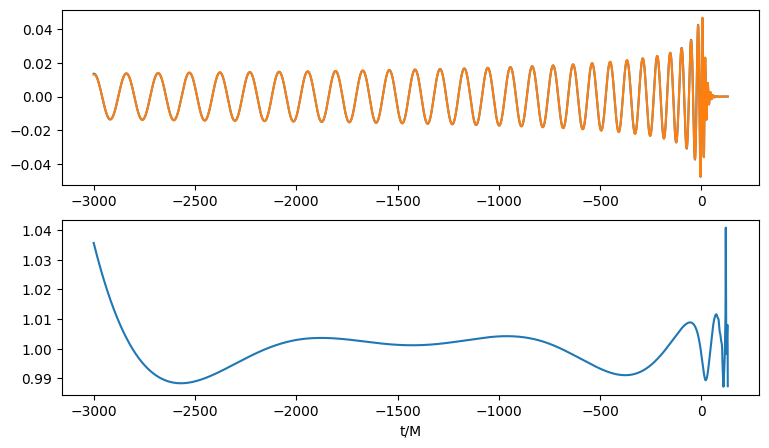

In [8]:
plt.figure(figsize=(9,5))

plt.subplot(211)
plt.plot(times,h)
plt.plot(times,rb.transform(h,q))


plt.subplot(212)

#plt.yscale("log")
plt.ylabel('',size=15)
plt.plot(times,h/rb.transform(h,q))
plt.xlabel("t/M");


Although domain partitioning is a powerful method for constructing reduced bases, increasing the number of partitions does not always produce better results. For example, let's see how the error varies with the hyperparameters lmax and nmax.

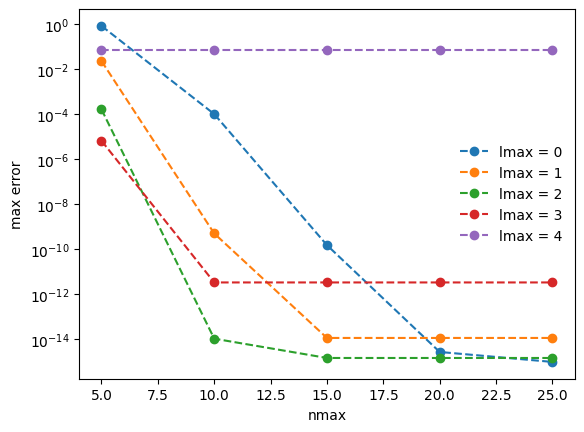

In [9]:
from skreducedmodel.reducedbasis import ReducedBasis

range_lmax = range(0,5)
range_nmax = range(5,26,5)

for lmax in range_lmax:
    max_errors = []
    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = 0,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )

        errors = []
        for h, q in zip(ts_test_normalized, q_test):
            # we project the waves with the hp-greedy model
            ht = rb.transform(h,q)
            # calculamos el error para la proyección
            errors.append(error(h, ht, times))

        # we take the maximum error in the validation set
        max_errors.append(np.max(errors))
    plt.plot(range_nmax, max_errors, "o--", label = f"lmax = {lmax}")

plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error");

In the reduced basis approach, a lower dimensionality of the basis implies representations with lower computational cost to be evaluated.

It is observed that there are cases where, to achieve a given accuracy, partitioning the domain results in bases with a lower dimensionality than a global one.

For example, to achieve representations with a maximum error of ~ 10e(-14), with lmax = 0 (without partitioning) a basis of dimension ~20 is needed, while with lmax=2 bases of dimension 10 at most are needed.

Now we tried the same experiment with another seed (index_seed_global_rb):

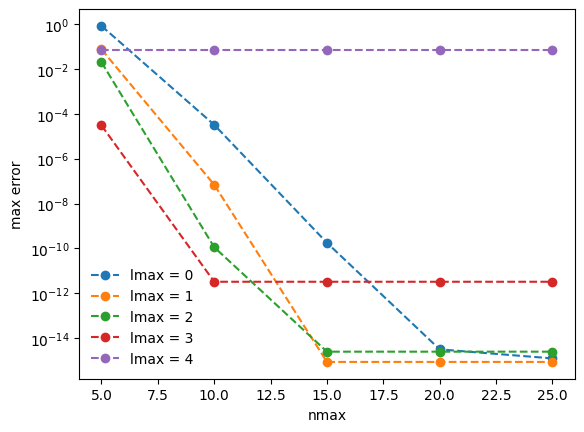

In [10]:
index_seed_global_rb = -1

range_lmax = range(0,5)
range_nmax = range(5,26,5)

for lmax in range_lmax:
    max_errors = []
    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = index_seed_global_rb,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )

        errors = []
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            ht = rb.transform(h,q)
            # calculamos el error para la proyección
            errors.append(error(h, ht, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors.append(np.max(errors))
    plt.plot(range_nmax, max_errors, "o--", label = f"lmax = {lmax}")

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")
plt.legend(frameon=False);

It can be seen that there is a dependence of the errors on the seed.

Therefore, the seed can be taken as a "relevant" hyperparameter of the model.

It is mentioned as "relevant" because in the non-partitioned case the choice of the seed gives results that can be taken as equivalent, as previous studies have shown that it does not affect the representability of the resulting bases, even if they are not constructed with exactly the same elements of the training space.

---------

### Empirical Interpolation Method

The reduced basis is a reduction of the parameter space of the system solutions. The next step to build a reduced model is to build an empirical interpolator that constitutes a reduction in the physical domain (in this case, time). 
To do so, we will use the EmpiricalInterpolation class that receives as input a reduced basis and selects the interpolation nodes to build an interpolator.

In [11]:
from skreducedmodel.empiricalinterpolation import EmpiricalInterpolation

# we built a reduced basis
rb = ReducedBasis(index_seed_global_rb = 0,
                  greedy_tol = 1e-16,
                  lmax = 0,
                  nmax = np.inf,
                  normalize = True,
                  integration_rule="riemann"
                  )

rb.fit(training_set = ts_train,
       parameters = q_train,
       physical_points = times
       )

# we built the empirical interpolator
eim = EmpiricalInterpolation(reduced_basis=rb)
eim.fit() 

A practical and efficient way to represent the training set is by empirical interpolation, which results in an efficient and accurate representation in most cases of interest. For example, let us see how the interpolation error is similar to the projection error.

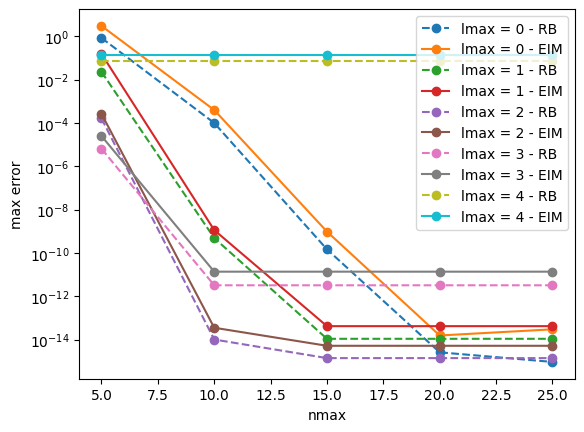

In [12]:
index_seed_global_rb = 0

range_lmax = range(0,5)
range_nmax = range(5,26,5)

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")


for lmax in range_lmax:
    max_errors_rb = []
    max_errors_eim = []

    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = index_seed_global_rb,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )
        
        eim = EmpiricalInterpolation(reduced_basis=rb)
        eim.fit()
        
        errors_rb = []
        errors_eim = []
        for h, q in zip(ts_test_normalized, q_test):
            # we calculate the wave projection with the hp-greedy model.
            h_rb = rb.transform(h,q)
            h_eim = eim.transform(h,q)
            
            # we calculate the error in the projection
            errors_rb.append(error(h, h_rb, times))
            errors_eim.append(error(h, h_eim, times))

        # we take the maximum error in the validation set.
        max_errors_rb.append(np.max(errors_rb))
        max_errors_eim.append(np.max(errors_eim))
        
    plt.plot(range_nmax, max_errors_rb, "o--", label = f"lmax = {lmax} - RB")
    plt.plot(range_nmax, max_errors_eim, "o-", label = f"lmax = {lmax} - EIM")

plt.legend();

### Surrogate

Finally, let's see how the Surrogate object works for building reduced models. To instantiate a Surrogate object, we can give it an EmpiricalInterpolation object, and then use the fit method to train the Surrogate object. For example, we build a reduced base (with default parameters), create the EIM and finally the reduced model. 

In [18]:
from skreducedmodel.surrogate import Surrogate

rb = ReducedBasis()
rb.fit(training_set = ts_train,
              parameters = q_train[:,0],
              physical_points = times
      )
eim = EmpiricalInterpolation(reduced_basis=rb)
eim.fit()
rom = Surrogate(eim=eim)
rom.fit()

For example, for a new parameter q let's see how we produce the real part of a wave. 

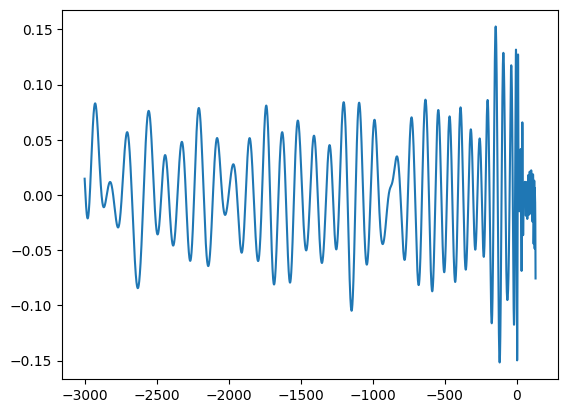

In [21]:
q = 7.5
plt.plot(times,np.real(rom.predict(q)))

In [ ]:
from skreducedmodel.reducedbasis import select_child_node

rb = ReducedBasis(lmax=1,greedy_tol=1e-15,nmax=20)
rb.fit(training_set = ts_train,
      parameters = q_train,
      physical_points = times
      )
tree = rb.tree

for leaf in tree.leaves:
    for parameter in leaf.train_parameters:
        leaf_select_child_node = select_child_node(parameter, tree)
        assert leaf_select_child_node == leaf

In [ ]:
rb = ReducedBasis(lmax=10,greedy_tol=1e-15,nmax=5)
rb.fit(training_set = ts_train,
      parameters = q_train,
      physical_points = times
      )
tree = rb.tree

for leaf in tree.leaves:
    for parameter in leaf.train_parameters:
        leaf_searched = rb.search_leaf(parameter, tree)
        assert leaf_searched == leaf